# Boise River Basin analysis
Compare the cumulative surface water input (SWI) which is the amount of rain on bare ground or snow melt leaving the bottom of the snowpack to calculated inflow into Lucky Peak reservoir. The inflows are calculated based on a mass balance of the reservoir and were obtained from the Buerau of Reclamation, Pacific Northwest Region [hydromet](https://www.usbr.gov/pn/hydromet/).

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import h5py
import numpy as np
import seaborn as sns
import pandas as pd

sns.set_context('paper')

In [2]:
# Read in the measured inflow data
inflow = pd.read_csv('station_data/LUC_WY2017_inflow.csv', index_col=0, parse_dates=[0])
inflow = inflow * 1.98 * 1233.48 # convert cfs to acre-feet to cubic meters

In [3]:
# Read in the data, this will take a little bit
em = h5py.File('../output/brb/devel/wy2017/awsm_paper/runs/run4368_6528/em.nc', 'r')
snow = h5py.File('../output/brb/devel/wy2017/awsm_paper/runs/run4368_6528/snow.nc', 'r')

# get the entire basin mask
mask_file = h5py.File('topo/topo.nc')
mask = mask_file['mask'][:]

# go through all timesteps and accumulate SWI in the BRB mask
# model outputs are at 23:00, floor to the day
start_date = pd.to_datetime('2017-04-01 00:00:00')
dt = [start_date + pd.to_timedelta(t, unit='h') for t in em['time']]
dt = [t.floor('D') for t in dt]

hrs = [t for t in em['time']]

swi_basin = pd.DataFrame(index=dt, columns=['SWI', 'SWI from snowmelt', 'SWI from rain'])
swi_accum = np.zeros_like(em['SWI'][0,:])
times = em['SWI'].shape[0]
mm2vol = 100 * 100 / 1000 # 100m2 pixel, and mm to meter
for i,t in enumerate(hrs):
    ti = start_date + pd.to_timedelta(t, unit='h')
    ti = ti.floor('D')
    
    # time step value
    swi = em['SWI'][i, :]
    swe = snow['specific_mass'][i, :]
    swi[mask == 0] = np.nan
    swe[mask == 0] = np.nan
        
    # accumulate pixel SWI
    swi_accum += swi
    
    # convert from mm SWI to meters and multiply by pixel size to get cubic meters
    idx = swe > 0 # locations with snow
    swi_total = mm2vol * np.nansum(swi)
    swi_snow = mm2vol * np.nansum(swi[idx])
    swi_rain = mm2vol * np.nansum(swi[~idx])
    swi_basin.loc[ti, :] = [swi_total, swi_snow, swi_rain]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in greater


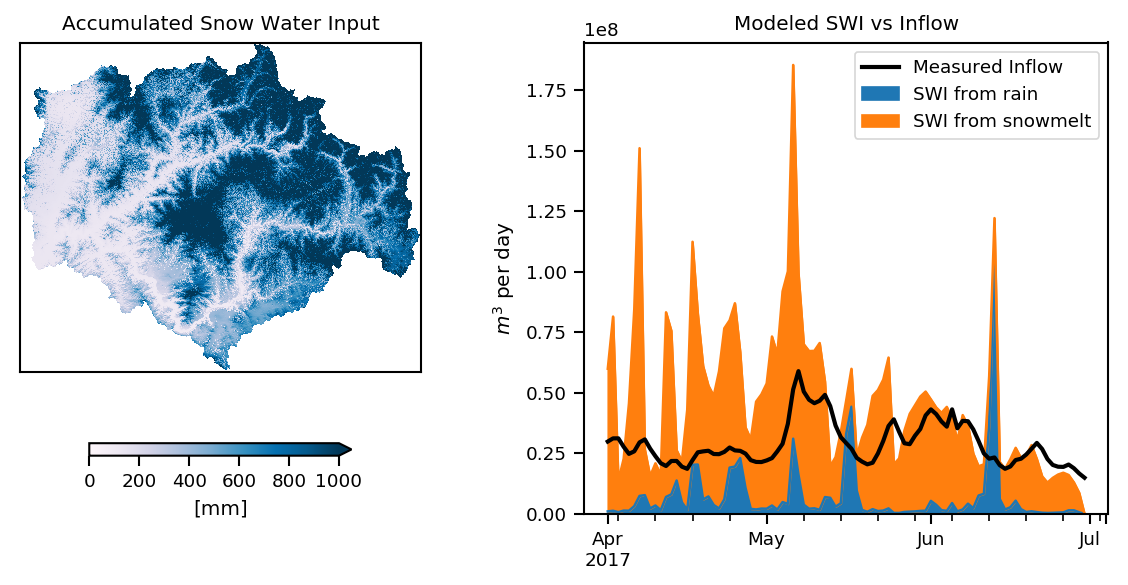

In [4]:
# Create the plots
# mask the SWI image
swi_accum[mask == 0] = np.nan

# create the colormap
colors1 = plt.cm.PuBu(np.linspace(0, 1, 128))
cmap = mcolors.LinearSegmentedColormap.from_list('swe_colormap', colors1)
cmap.set_bad('white',1.)

# Plot the figure
fig, (ax1, ax2) = plt.subplots(figsize=(8, 4), dpi=150, nrows = 1, ncols = 2)

# plot accumulated SWI map
s = ax1.imshow(swi_accum, vmin=0, vmax=1000, cmap=cmap, interpolation='none')
s.axes.get_xaxis().set_ticks([])
s.axes.get_yaxis().set_ticks([])
ax1.set_title('Accumulated Snow Water Input')

# Add the colorbar
cbar = fig.colorbar(s, ax=ax1, extend='max', shrink=0.5, orientation='horizontal')
cbar.set_label('[mm]')

# plot the SWI timeseries
df = pd.concat([swi_basin, inflow], axis=1)
df['Inflow'] = df['luc_qu']
df[['SWI from rain', 'SWI from snowmelt']].plot.area(ax=ax2)
df['Inflow'].plot(ax=ax2, color='k', linewidth=2, label='Measured Inflow')

ax2.legend()
ax2.set_title('Modeled SWI vs Inflow')
ax2.set_ylabel('$m^3$ per day')

plt.tight_layout()
plt.savefig('brb_figure.png', dpi=200)